Tak jak rozmawialiśmy to jest jedynie bardzo początkowe przejrzenie tych metod (dalej tej Doc2Vec wygląda dość dziwnie), ale przynajmniej wstępne wyniki wyglądają jakby miało to jakiekolwiek szanse zadziałać :D

Sekwencja czynności przy framework'u **WL**:
1. wczytanie grafu przy założeniu, że feature'ami będą stopnie wierzchołków;
2. na podstawie stopni wierzchołków i ich sąsiadów, generujemy nowe charakterystyki $\rightarrow$ "podobny label" mają wierzchołki, które są podobnego stopnia i ich sąsiedzi są podobnych stopni;
3. na podstawie listy nowoutworzonych cech tworzona jest instancja klasy `TaggedDocument`, gdzie tagiem jest nazwa grafu;
4. utworzony w kroku $3.$ dokument podawany jest na wejściu `Doc2Vec'a`.

References:
- https://docs.cogdl.ai/en/latest/_modules/cogdl/models/emb/graph2vec.html
- https://towardsdatascience.com/beyond-weisfeiler-lehman-approximate-isomorphisms-and-metric-embeddings-f7b816b75751

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import json
import glob

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
from typing import Tuple, List

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.linear_model import LogisticRegression

from IPython.display import Markdown, display
from tqdm.notebook import tqdm

sys.path.append("../")
from src.graph2vec import OurGraph2Vec, Ensemble_G2V

plt.rcParams["figure.figsize"] = (16, 8)

In [2]:
def read_stargazers_dataset(path: str) -> Tuple[List, pd.Series]:
    """
    Function to read the graphs and their labels from github Stargazers dataset.
    Args:
        path (str): path to the dataset

    Returns:
        Tuple[List,pd.Series]: A tuple consisting of a list of NetworkX graphs and a pd.Series of their respective labels
    """
    data_path = os.path.join(path, "git_edges.json")
    target_path = os.path.join(path, "git_target.csv")
    with open(data_path) as f:
        json_content = json.load(f)
    target = pd.read_csv(target_path, index_col="id").squeeze("columns")
    return [nx.Graph(elem) for key, elem in json_content.items()], target

In [3]:
def calculate_measure(func, G, kwargs={}):
    return func(G, **kwargs)

In [4]:
def cross_validate(
    X, y, estimator=LogisticRegression(), verbose: bool = False, **kwargs
):
    results = cross_val_score(estimator, X=X, y=y, **kwargs)
    if verbose:
        print(f"Estimated accuracy:{results.mean():.04f} std:{results.std():.04f}")
    return results

In [5]:
graphs, labels = read_stargazers_dataset("../datasets/github_stargazers")

len(graphs)

12725

In [6]:
def weighted_mean(alpha: float):
    return lambda x, y: alpha * x + (1 - alpha) * y


def select_by_var(arr: np.array, alpha: float):
    variances_ord = np.var(arr, axis=0).argsort()[::-1]
    return arr[:, variances_ord][:, : int(alpha * arr.shape[1])]


def by_weighted_variance(alpha: float):
    return lambda x, y: np.concatenate(
        (select_by_var(x, alpha), select_by_var(y, 1 - alpha)), axis=1
    )

## Parameters section

In [7]:
subset_card = len(graphs)  # number of graphs
cross_val_k = 13  # number of folds to perform in cross-validation (could be odd int or LeaveOneOut())

In [8]:
MEASURES = [
    # nx.pagerank,
    nx.closeness_centrality,
    # nx.degree_centrality,
    nx.current_flow_closeness_centrality,
    # nx.information_centrality,  # identical to: current_flow_closeness_centrality
    # nx.betweenness_centrality,
    # nx.current_flow_betweenness_centrality, #too long (50 minutes :'( )
    # nx.approximate_current_flow_betweenness_centrality,
]

KWARGS_DICT = {
    nx.pagerank: {},
    nx.closeness_centrality: {},
    nx.degree_centrality: {},
    nx.current_flow_closeness_centrality: {},
    # nx.information_centrality: {},
    nx.betweenness_centrality: {},
    nx.current_flow_betweenness_centrality: {},
    nx.approximate_current_flow_betweenness_centrality: {},
}

In [9]:
tested_range = np.linspace(0, 1, 26)
WEIGHTING_FUNCTIONS = (
    {f"w_m_{a}": weighted_mean(a) for a in tested_range}
    | {f"w_v_{a}": by_weighted_variance(a) for a in tested_range}
    | {f"concat": lambda x, y: np.concatenate((x, y), axis=1)}
)

## Execution section

In [10]:
graphs_subset = graphs[:subset_card]

order_dict = {}
without = OurGraph2Vec()  # without
with_dm = OurGraph2Vec(cbowlike=True)  # with_dm (experiment)
ens_model = Ensemble_G2V(without, with_dm)

In [11]:
# in this cell, we create a dictionary of orders with the following structure:
# order_dict = {
#    measure: nested list of nodes sorted wrt. measure
# }

for measure in tqdm(MEASURES):
    # centralities calc.
    print(f"Calculating {measure.__name__}...")

    centralities = [None] * subset_card
    for idx, G in tqdm(enumerate(graphs_subset), total=subset_card):
        centralities[idx] = calculate_measure(
            func=measure, G=G, kwargs=KWARGS_DICT[measure]
        )

    # ordering wrt. centralities
    print(f"Ordering wrt. {measure.__name__}...")
    ams = [None for i in range(subset_card)]

    for it, central_dict in tqdm(enumerate(centralities), total=subset_card):
        ams[it] = np.array(sorted(central_dict, key=central_dict.get), dtype=np.int64)

    order_dict[measure] = ams

  0%|          | 0/2 [00:00<?, ?it/s]

Calculating closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

Ordering wrt. closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

Calculating current_flow_closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

<class 'networkx.utils.decorators.argmap'> compilation 20:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Ordering wrt. current_flow_closeness_centrality...


  0%|          | 0/12725 [00:00<?, ?it/s]

'closeness_centrality'

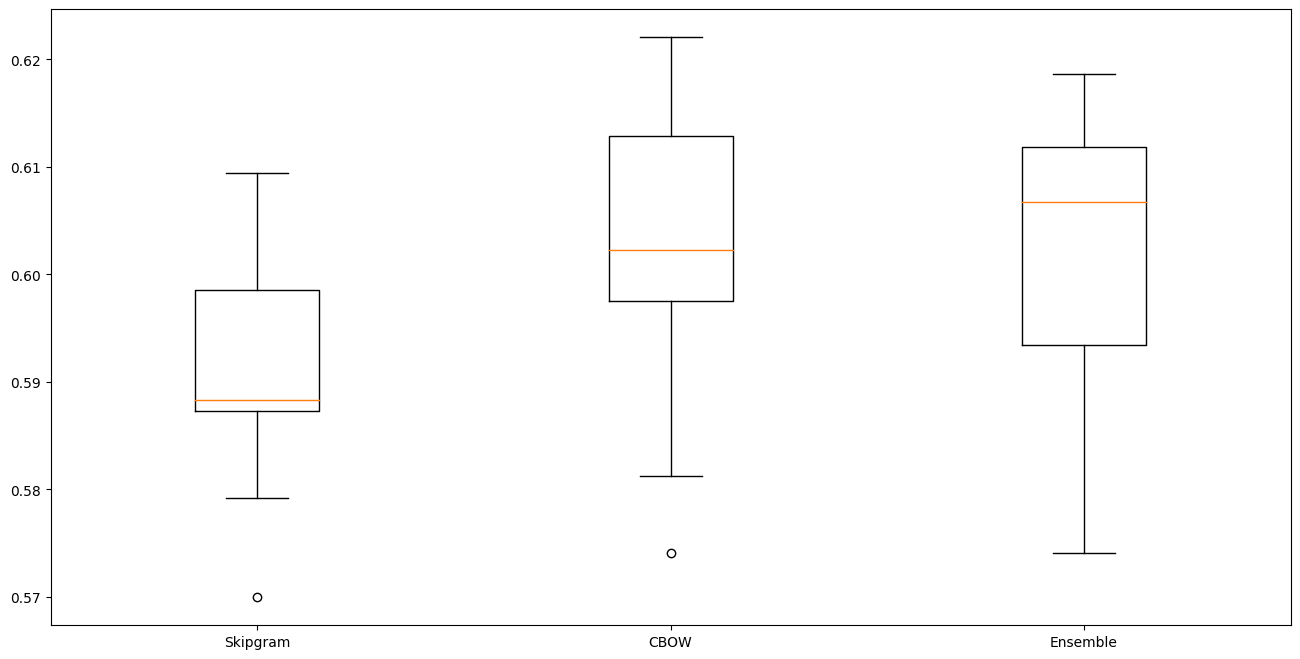

'current_flow_closeness_centrality'

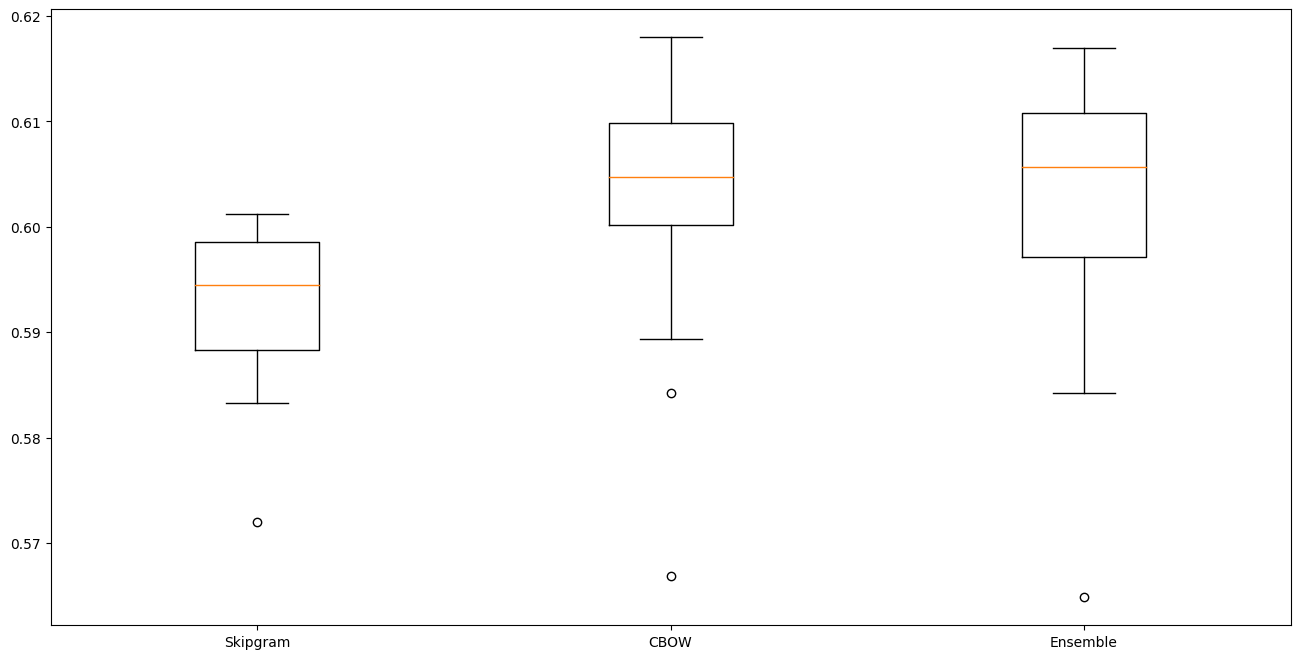

In [12]:
# in this cell we run experiments for all measures

for measure, order in order_dict.items():
    display(measure.__name__)

    # benchmark
    without.fit(graphs_subset, orderings=order)
    with_dm.fit(graphs_subset, orderings=order)
    ens_model.fit(graphs_subset, orderings=order)

    # experiment
    no_dm_res = cross_validate(without.get_embedding(), labels, cv=cross_val_k)
    dm_res = cross_validate(with_dm.get_embedding(), labels, cv=cross_val_k)
    ens_res = cross_validate(ens_model.get_embedding(), labels, cv=cross_val_k)

    # results
    res_nested_list = [no_dm_res, dm_res, ens_res]
    axis_labels = ["Skipgram", "CBOW", "Ensemble"]

    n_items = len(res_nested_list)
    plt.boxplot(res_nested_list, positions=range(n_items))
    plt.xticks(range(n_items), labels=axis_labels[:n_items])
    plt.show()

### Evaluating the model's performance via k-fold cross-validation

In [13]:
plt.rcParams["figure.figsize"] = (16, 40)

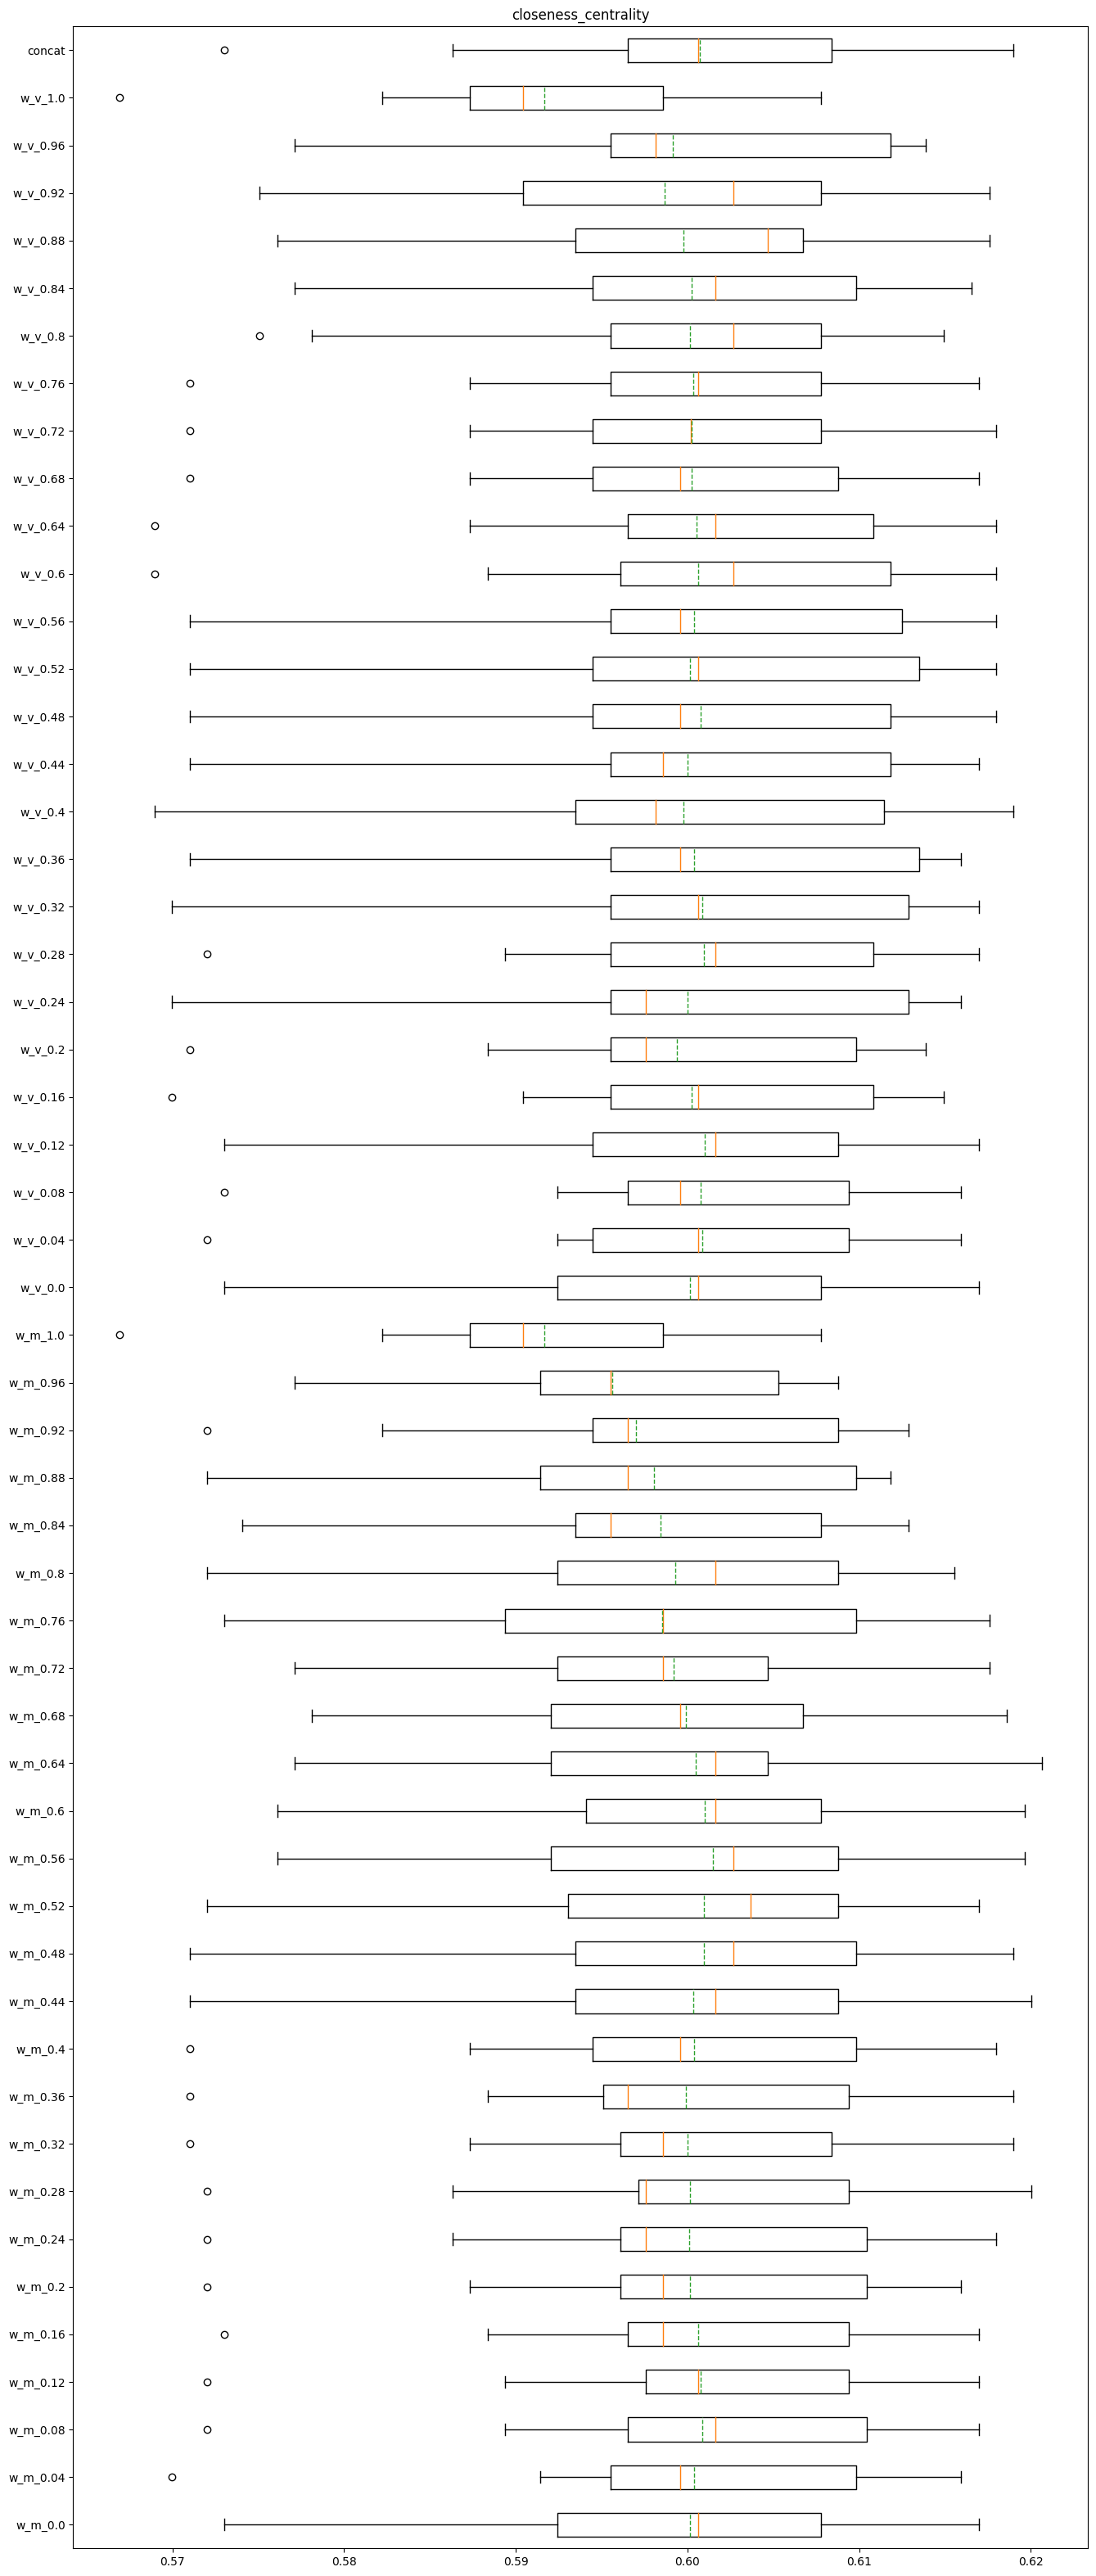

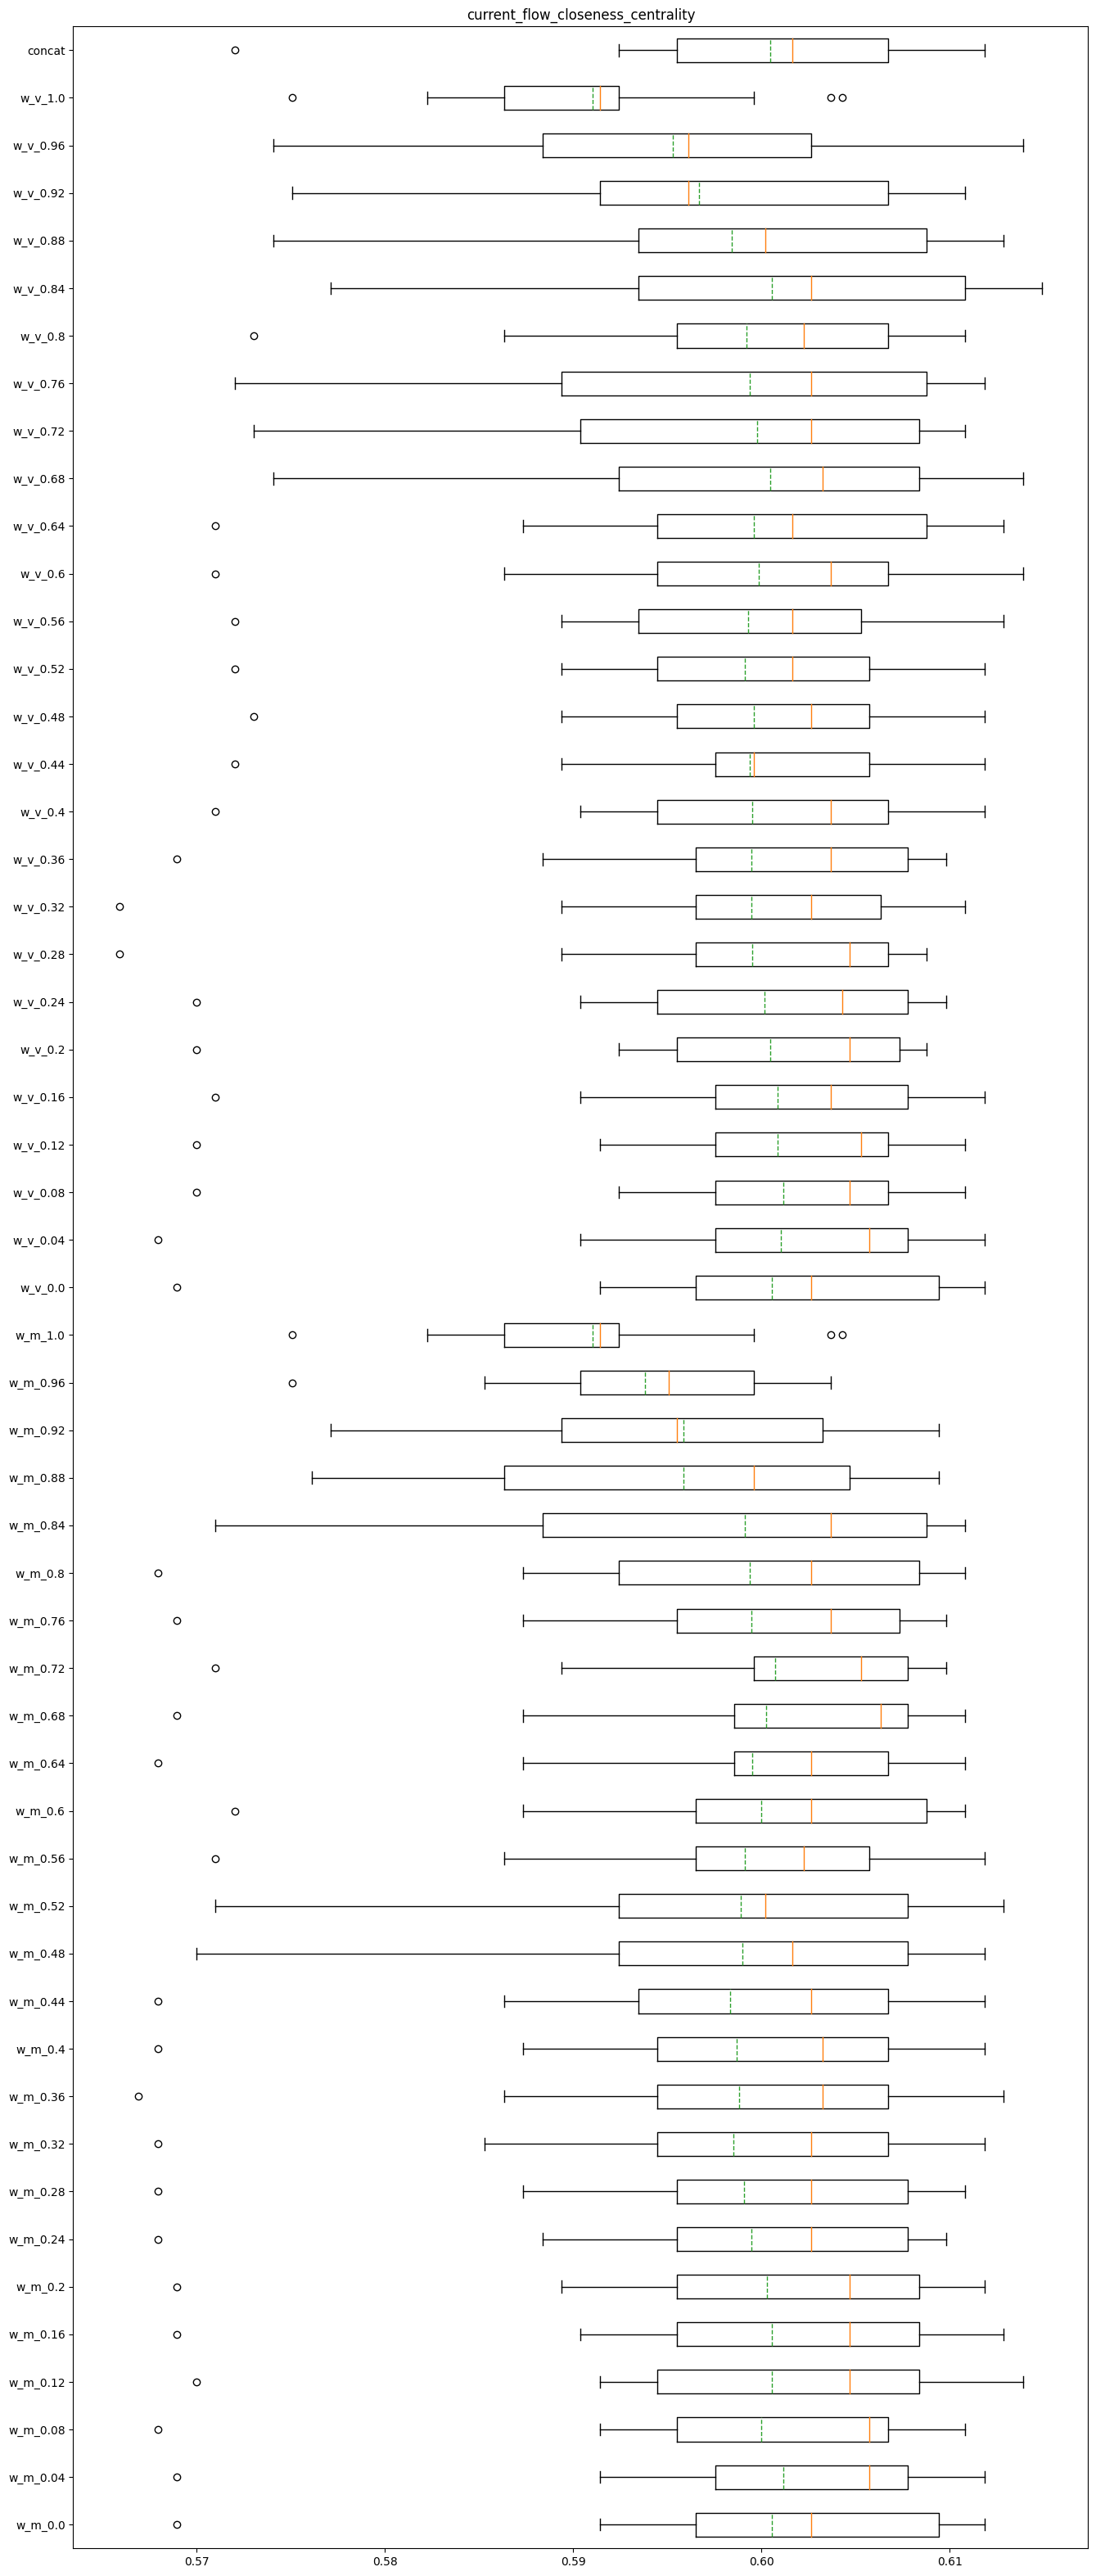

In [18]:
for measure, order in order_dict.items():
    res = {}
    without.fit(graphs_subset, orderings=order)
    with_dm.fit(graphs_subset, orderings=order)
    for name, func in WEIGHTING_FUNCTIONS.items():
        ens_model.set_weighting_function(func)
        res[name] = cross_validate(ens_model.get_embedding(), labels, cv=cross_val_k)
    n_items = len(res)
    plt.title(measure.__name__)
    plt.boxplot(res.values(), positions=range(n_items), vert=False, showmeans=True,meanline=True)
    plt.yticks(range(n_items), labels=res.keys())
    plt.show()